In [428]:
# importing libaries
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import math as math

In [429]:
#read data 
data = pd.read_csv('Almeria_Airp_-hour.dat',delimiter='\t')
data = data[1:].astype(float)
data.Ta +=273.15 #convert to Kelvin
data['date_time'] = pd.to_datetime({'year':2022,'month':data.m,'day':data.dofm,'hour':data.hi})

In [430]:
'''dofm: day of month
    dofy: day of the year
    hi: hour of the day
    Ta: temperature of air
    G_Gh: 
    Td: dew point temperature
    RH: relative himidity (%)
    G_DH: 
    FF: wind speed (m/s)
    DD: wind direction
    Lin: longwave radiation from the atmosphere
    RR: preciptation
    Sd: effective sunshine duration
    N: cloud cover
    hs: solar altitude
    TL: 
    G_Bn: 
    G_Gc: 
    GEX: Extraterrestrial radiation
    G_Ghmod: 
    PAR: Photosynthetically active radiation
    Snd: 
    Lup: Longwave (thermal, infrared) radiation on horizontal surface emitted from the earth's surface (longwave 
        outgoing) wavelength > 3 µm
'''
data.FF.describe()


count    8760.000000
mean        3.919840
std         2.390256
min         0.000000
25%         2.100000
50%         3.500000
75%         5.300000
max        15.100000
Name: FF, dtype: float64

In [431]:
sigma = 5.670374419*10**-8          # boltzman constant 
tau_reactor = 0.92                  # transmittance according to manufacturer taken when not filled with water
epsilon_reactor = 0.97              # emsivity of water
glass_thickness = 2.2*10**-3 
R_reactor = (65*(10**-3)-2*glass_thickness)/2           # according to manufacurer
L = 1                               # an arbitraty length of a meter of reactor is used
rho_reactor = 997                            # desity of water
cp_reactor = 4186                          # soortelijke warmte water volgens wikipedia J/(Kg*K)
V_reactor = L*math.pi*R_reactor**2      # reactor volume in m^3 
epsilon_air = 1                     # value used in paper mechanistic modeling 
dilution_rate = 0.05/3600                 # random suggestion
T_in = 273.15+13
aeration_rate = 1*V_reactor/3600       #arbitrary aeration rate in volume/time unit  
R = 8.314                                        # ideal gas constant
A = 8.07131                                      # constant for antoines law found on the wikipedia page 
B = 1730.63                                      # constant for antoines law found on the wikipedia page 
C  = 233.426 - 273.15                            # constant for antoines law found on the wikipedia page                       
heat_vap = 40.66*1000                                # heat of vaporization according to table on wikipedia (J/mol)
albedo = 0.3                            # according to wikipedia for grassland
A_cross = 2*R_reactor*L                 # Area cross section
flow_speed_reactor = 1                  # vary 0.1-1 m/s
g = 9.81                    # gravity constant 
a_a = 23.07*10**-6                      # air diffusifiy
v_a =  1.48*10**-5                     #air kinematic viscosity 
lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
Pr = 0.7                        #given in paper for a value at 25 C
 # forced convection
mu_reactor = 1*10**-3               # viscosity water (kg m/s) 
mu_air =      1.81*10**-5           # viscosity air  (kg m/s)
rho_air = 1.204                     #kg/m3
lambda_glass = 1.2                  # termal resistance glass (W/(m*K)) according to brochure 
V_reactor
k_reactor = 0.598                       # thermal conductivity water (W/(mK))
k_air = lambda_a
mu_a = v_a 
rho_a = 1.293
cp_air = 1000.5                     # specific heat air (J/kg/K)
saved_fluxes = []
k_air

0.026

In [432]:
time_int = 3600
t_span = np.array((data.dofy*24+data.hi-24)*time_int)
t_start = 24*5*30
t_span = t_span[t_start:t_start+48]
t0 = [0]
y0 = [273.15+13]
p = [1, 1]
t_span

array([12963600., 12967200., 12970800., 12974400., 12978000., 12981600.,
       12985200., 12988800., 12992400., 12996000., 12999600., 13003200.,
       13006800., 13010400., 13014000., 13017600., 13021200., 13024800.,
       13028400., 13032000., 13035600., 13039200., 13042800., 13046400.,
       13050000., 13053600., 13057200., 13060800., 13064400., 13068000.,
       13071600., 13075200., 13078800., 13082400., 13086000., 13089600.,
       13093200., 13096800., 13100400., 13104000., 13107600., 13111200.,
       13114800., 13118400., 13122000., 13125600., 13129200., 13132800.])

In [433]:
def ground_reflected_rad(t,y,time_index):
    Q = albedo*(data.G_Dh[time_index]+data.Lin[time_index]+data.G_Gh[time_index])*2*R_reactor*L*tau_reactor*epsilon_reactor
    return Q
ground_reflected_rad(1,300,15)

np.float64(13.70913804)

In [434]:
def Q_evap(t,y,time_index):             #perfect equilibrium of water and air is reached at the outlet
    vap_pres_in = 10**(A-(B/(C+data.Ta[time_index])))       #antoines law
    moles_in = vap_pres_in*aeration_rate*(data.RH[time_index]/100)/(R*data.Ta[time_index])
    vap_pres_out = 10**(A-(B/(C+y)))
    moles_out = vap_pres_out*aeration_rate/(R*y) 
    Q = (moles_out-moles_in)* heat_vap
    return -Q
Q_evap(1,300,15)

np.float64(-0.00024634029551321254)

In [435]:
def flow_medium_in(t,y,time_index):
    if data.G_Gh[time_index]>0:         #only harvest when it there is light, since it is only growing in that case
        Q = dilution_rate*T_in*rho_reactor*cp_reactor*V_reactor     # dubblecheck if we are now not replacing the volume every second 
    else:
        Q = 0
    return Q
flow_medium_in(1,273,15)
    

47.83995536999386

In [436]:
def flow_harvest_out(t,y,time_index):
    if data.G_Gh[time_index]>0:         #only harvest when it there is light, since it is only growing in that case
        Q = dilution_rate*y*rho_reactor*cp_reactor*V_reactor     # dubblecheck if we are now not replacing the volume every second 
    else:
        Q = 0
    return -Q
flow_harvest_out(1,300,15)

-50.155466052763096

In [437]:
def ground_infrared_radiation(t,y,time_index):      #assume the Lup value is indeed the emmited ground radiation
    Q = tau_reactor*epsilon_reactor*data.Lup[time_index]*2*R_reactor*L
    return Q
ground_infrared_radiation(1,273,1)

np.float64(20.65834608)

In [438]:
def reactor_infrared_radiation(t,y,time_index):
    Q = L*sigma*tau_reactor*epsilon_reactor*2*math.pi*R_reactor*y**4 
    return -Q
reactor_infrared_radiation(1,273,1)
    

-53.51116217701865

In [439]:
def diffuse_solar_rad(t,y,time_index):
    Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Dh[time_index]
    return Q
diffuse_solar_rad(1,300,15)

np.float64(8.9231076)

In [440]:
def direct_solar_rad(t,y,time_index): #in the paper they do something with a formfactor here, check later why
    #Q = tau_reactor*epsilon_reactor*epsilon_air*sigma*R_reactor*2*L*data.G_Gh[time_index] #the amount of sunlight available * intersection area* amount of light not refrlected * light taken up
    Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Gh[time_index]
    return Q
direct_solar_rad(1,273,15)

np.float64(19.7389956)

In [441]:
def infrared_rad_air(t,y,time_index):
        #Q = tau_reactor*epsilon_reactor*epsilon_air*2*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        Q = data.Lin[time_index]*R_reactor*2*L*tau_reactor*epsilon_reactor
        return Q
def infrared_rad_air2(t,y,time_index):
        Q = tau_reactor*epsilon_reactor*epsilon_air*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        return Q
def infrared_rad_air_rocca(t,y,time_index):
        Cc = data.N[time_index] #cloud coverage 
        Em = 0.937*(10**-5)* (data.Ta[time_index]**2)*(1+0.17*(Cc/8)**2)                # cloud cover divided by 8 because of the scale (octa) used 
        lambda_heat = 0.7
        Q = sigma*(data.Ta[time_index]**4)*math.sqrt(lambda_heat*Em)*epsilon_air*tau_reactor*R_reactor*2*L
        return Q

infrared_rad_air(1,27,1)

np.float64(17.3054208)

In [442]:
def convection2(t,y,time_index):
    temp_diff = data.Ta[time_index]-y
    return temp_diff
    

In [443]:
def convection(t,y,time_index):
    #new constants 
    g = 9.81                    # gravity constant 
    a_a = 23.07*10**-6                      # air diffusifiy
    v_a =  1.48*10**-5                     #air kinematic viscosity 
    k_reactor = 0.598                       # thermal conductivity water (W/(mK))
    lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
    Pr = 0.7                        #given in paper for a value at 25 C
    k_air = lambda_a
    # forced convection
    mu_reactor = 1*10**-3               # viscosity water (kg m/s) 
    mu_air =      1.81*10**-5           # viscosity air  (kg m/s)
    rho_air = 1.204                     #kg/m3
    mu_a = v_a 
    rho_a = 1.293
    cp_air = 1000.5                     # specific heat air (J/kg/K)

    # Calculating dimensionless numbers
    Re_reactor = rho_reactor*flow_speed_reactor*(2*R_reactor)/mu_reactor
    #Pr_reactor = 50000/((y-273.15)**2+155*(y-273.15)+3700)          # according to wikipedia
    Re_air = rho_air*data.FF[time_index]*2*(R_reactor+glass_thickness)/mu_air           # formula according to wikipedia 
    #Pr_air = 10**9/(1.1*(data.Ta[time_index]-273.15)**3-1200*(data.Ta[time_index]-273.15)**2+322000*(data.Ta[time_index]-273.15)+1.393*10**9) # formula according to wikipedia
    #Ra = (g*abs(y-data.Ta[time_index])*L**3)/(a_a*v_a*data.Ta[time_index])
    #Re = rho_a*2*R_reactor*data.FF[time_index]/mu_a
    #h_forced = lambda_a/(2*R_reactor)*(0.3+0.62*(Re**0.5)*(Pr**(1/3))/(1+(0.4/Pr)**(2/3))**0.25)*(1+(Re/282000)**(5/8))**0.8
    
    #old calculation
    #h_co = lambda_a/L*(0.825+(0.387*Ra**(1/6))/((1+(0.492/Pr)**(9/16))**8/27))**2
    #Q = h_forced*(data.Ta[time_index]-y)*math.pi*R_reactor*L
    Pr_air = cp_air*mu_air/k_air
    Pr_reactor = cp_reactor*mu_reactor/k_reactor



    #Dont forget the case where there is no wind and therefore natural convection only occurs
    if Re_air<= 4000:                   # according to tabel 7.2 in book 'fundamentals of heat and mass transfer'
        C = 0.683
        m = 0.385
    elif Re_air<=40000:
        C = 0.193
        m = 0.618
    elif Re_air<=4000000:
        C = 0.027
        m = 0.805
    elif Re_air==0:
        return 0
    else:
        return 0
    Nu_air = C*(Re_air**m)*(Pr_air**(1/3))
    Nu_inside = 0.027*(Re_reactor**0.8)*(Pr_reactor**0.33)*(L+0.7*((2*R_reactor))/L)   # for Re>2000 accroding to reader transfer processes
    R_inside = 1/(Nu_inside*k_reactor*math.pi*L)                       
    R_glass = math.log((R_reactor+glass_thickness)/R_reactor)/(2*math.pi*L*lambda_glass)    # according to tabel 7.2 in book 'fundamentals of heat and mass transfer' 3.26
    R_outside = 1/(Nu_air*k_air*math.pi*L)
    Rtot = R_inside+R_glass+R_outside
    Q = (data.Ta[time_index]-y)/Rtot
    #Q = data.Ta[time_index]-y
    return Q
convection(1,292,15)    

np.float64(-0.9118654421396749)

In [444]:
#functions
def heat_bal(t,y,p):
    '''creating the measured values at time t as input'''
    time_index = (t//3600)                    # the algorithm loop over this heat balance more often than just for every step, therefore the // to indix to the right value
    u = data.Ta[time_index]
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
    Q_air_infrared = infrared_rad_air(t,y,time_index)
    Q_medium_added  = flow_medium_in(t,y,time_index)
    Q_broth_out = flow_harvest_out(t,y,time_index)
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
    Q_evaporation = Q_evap(t,y,time_index)
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)
    Q_convection =  convection(t,y,time_index)
    saved_fluxes.append([time_index])
    #if t%3600==0:
    #    saved_fluxes.append([t,Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_evaporation,Q_convection]
    #else:
    #   pass
    '''To be implemented: pump, airation, convection   '''
    dxdt = (Q_direct_solar_rad+Q_diffuse_solar_rad+Q_ground_radiation+Q_medium_added+Q_air_infrared+Q_ground_reflected+Q_react_infrared+Q_broth_out+Q_evaporation+Q_convection)/(rho_reactor*cp_reactor*V_reactor)
    return dxdt
heat_bal(7200,10,1)

np.float64(-6.414926621333524e+58)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.296e+07  1.297e+07 ...  1.313e+07  1.313e+07]
        y: [[ 2.861e+02  2.869e+02 ...  2.918e+02  2.903e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 374
     njev: 0
      nlu: 0
[3601.0]
[np.float64(3603.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3601.0)]
[np.float64(3602.0)]
[np.float64(3603.0)]
[np.float64(3603.0)]
[np.float64(3603.0)]
[np.float64(3601.0

374

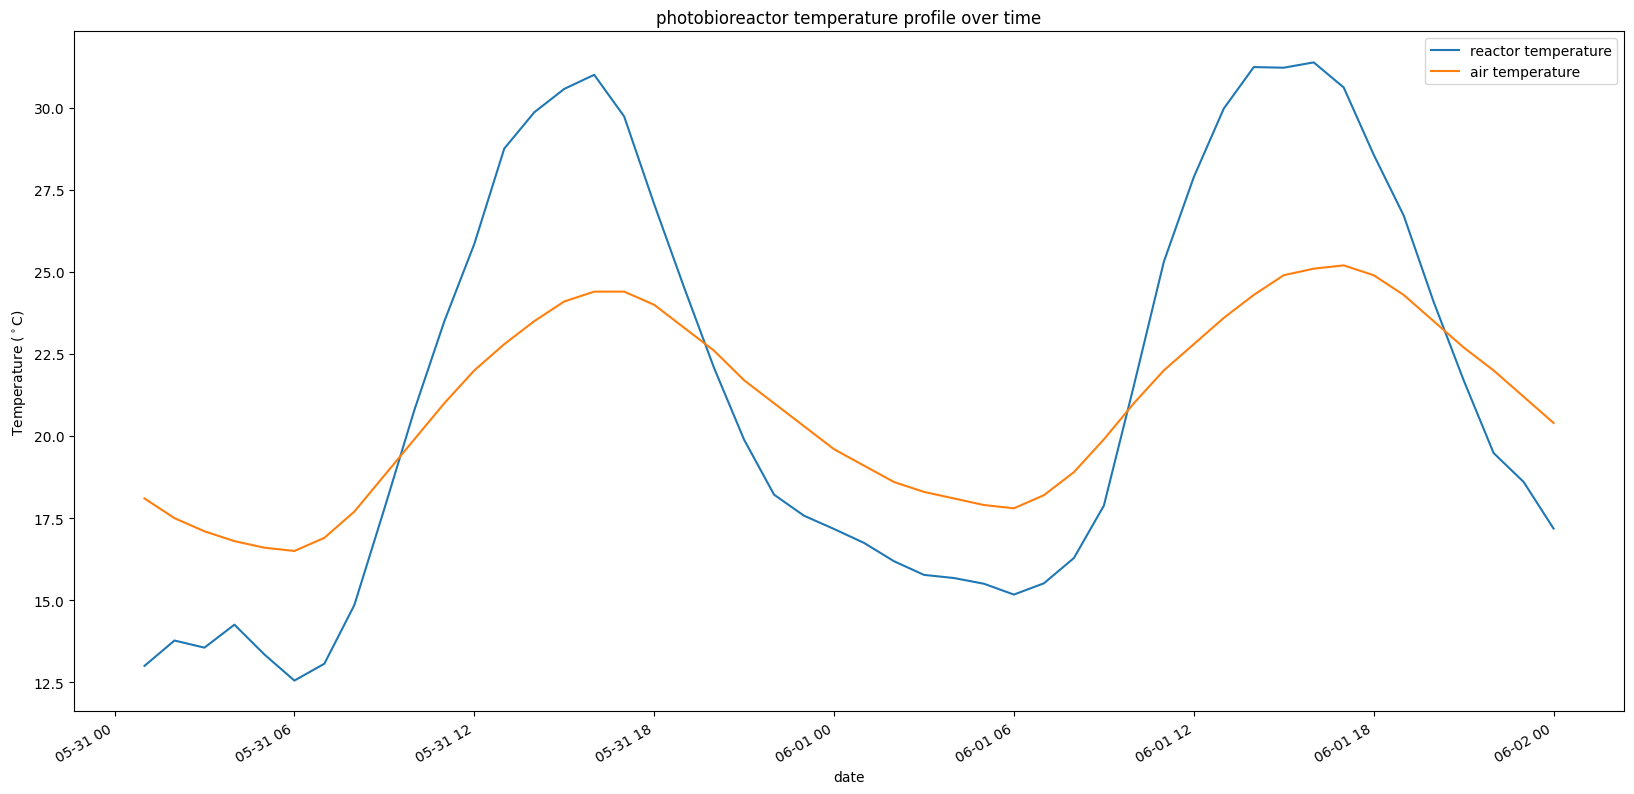

In [445]:
#solver
saved_fluxes=[] 
solver = integrate.solve_ivp (heat_bal,(t_span[0],t_span[-1]) ,y0, args = [0.01],t_eval=t_span, method='RK45')
#solver = integrate.solve_ivp (heat_bal,[0, t_span[-1]], y0, t_eval=t_span, args = [0.0000001])
print(solver)
t_vals = solver.t
y_vals_check = solver.y
y_vals = y_vals_check[0]                #Did this to overcome the problem that the values are stored in a matrix. 
hours = t_span/(time_int*24)
air_temp = data.Ta[hours*24]
t_vals_days = 24/hours
time_values = data.date_time[t_span/time_int]
#Q_data = pd.DataFrame(Q_vals,time_values[1:])

##          plot results
plt.xlabel('date')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('photobioreactor temperature profile over time')
plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15)
plt.gcf().autofmt_xdate()
plt.legend(['reactor temperature','air temperature'])
y_vals_check
#flux_array = np.array(saved_fluxes)
#flux_array[:,0]
for item in saved_fluxes:
    #time = float(item[0])/3600
    time = item
    #if time%1<=0.01:
    print(time)
len(saved_fluxes)

Text(0, 0.5, 'heat flux (W)')

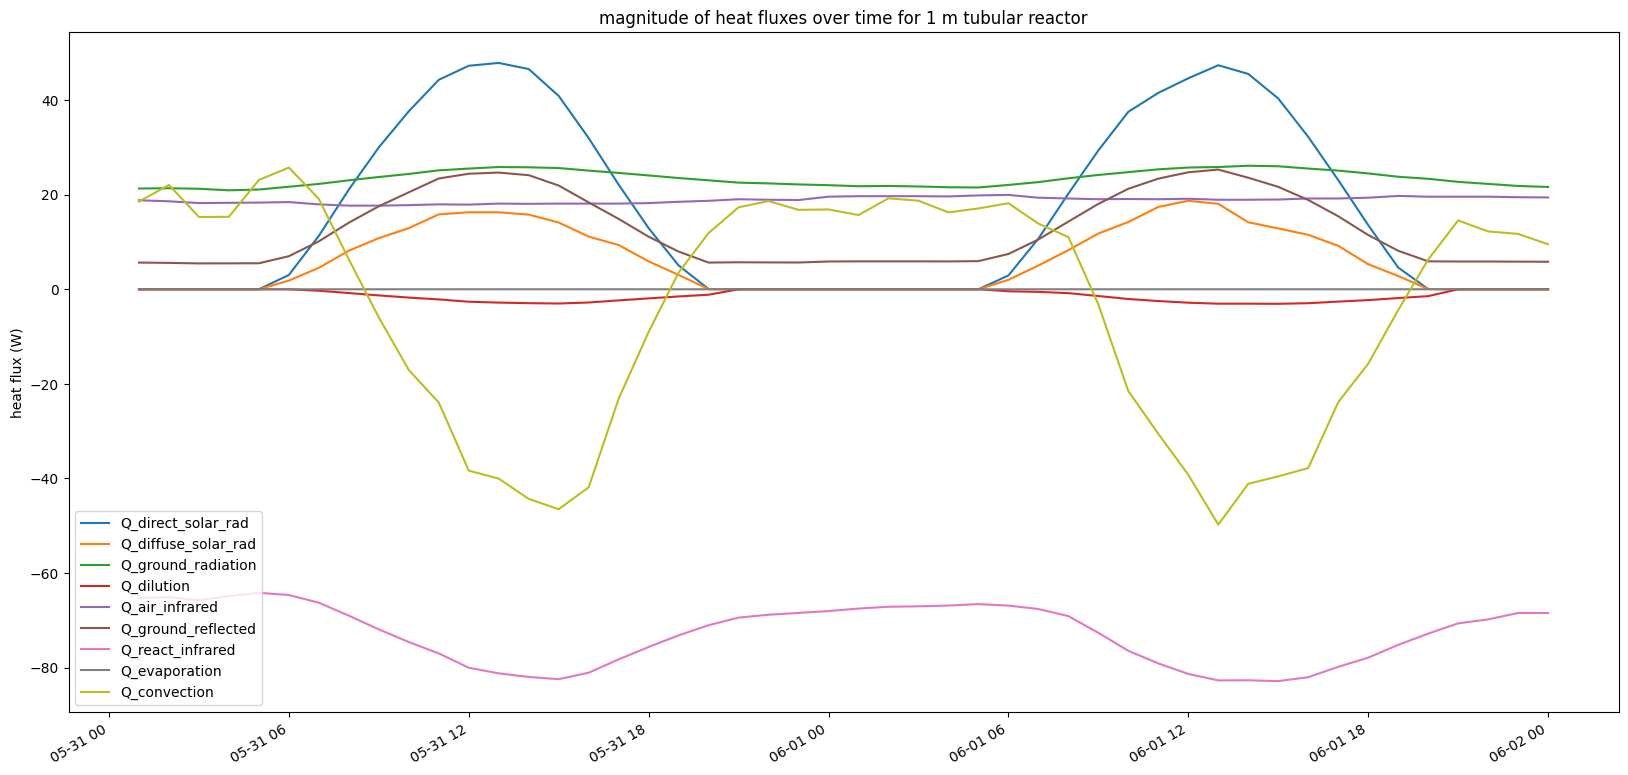

In [446]:
#reverse engineer the heat fluxes, can not extract them directly out of the heat balance function because the integration method
# integration method loops over heat balance multiple times per time step.
Q_data = np.zeros((len(t_vals)+1,9))
time_index = t_span[0]/3600
general_index = 0
for t in t_vals:
    general_index += 1
    time_index+=1
    try: 
        y = y_vals[general_index]
    except:
        pass
    #time_index+=1                       #during the calculation the previous y values are inputted, and the time index is of the next hour, in this way this reverse engineering compensates for that
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
    Q_air_infrared = infrared_rad_air(t,y,time_index)
    Q_dilution  = flow_medium_in(t,y,time_index)+flow_harvest_out(t,y,time_index)
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
    Q_evaporation = Q_evap(t,y,time_index)
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)
    Q_convection =  convection(t,y,time_index)
    #time_index-=1
    Q_data[general_index] = [Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_dilution,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_evaporation,Q_convection]
    
#Q_vals.append([Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_medium_added,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_broth_out,Q_evaporation])
Q_data = Q_data[1:]
columnheader = ['Q_direct_solar_rad','Q_diffuse_solar_rad','Q_ground_radiation','Q_dilution','Q_air_infrared','Q_ground_reflected','Q_react_infrared','Q_evaporation','Q_convection']
Fluxes = pd.DataFrame(Q_data, index= time_values,columns=columnheader)
Fluxes.describe()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(time_values,Fluxes)
plt.legend(columnheader)
plt.gcf().autofmt_xdate()
plt.title('magnitude of heat fluxes over time for 1 m tubular reactor')
plt.ylabel('heat flux (W)')

Text(0, 0.5, 'Heatflux (W)')

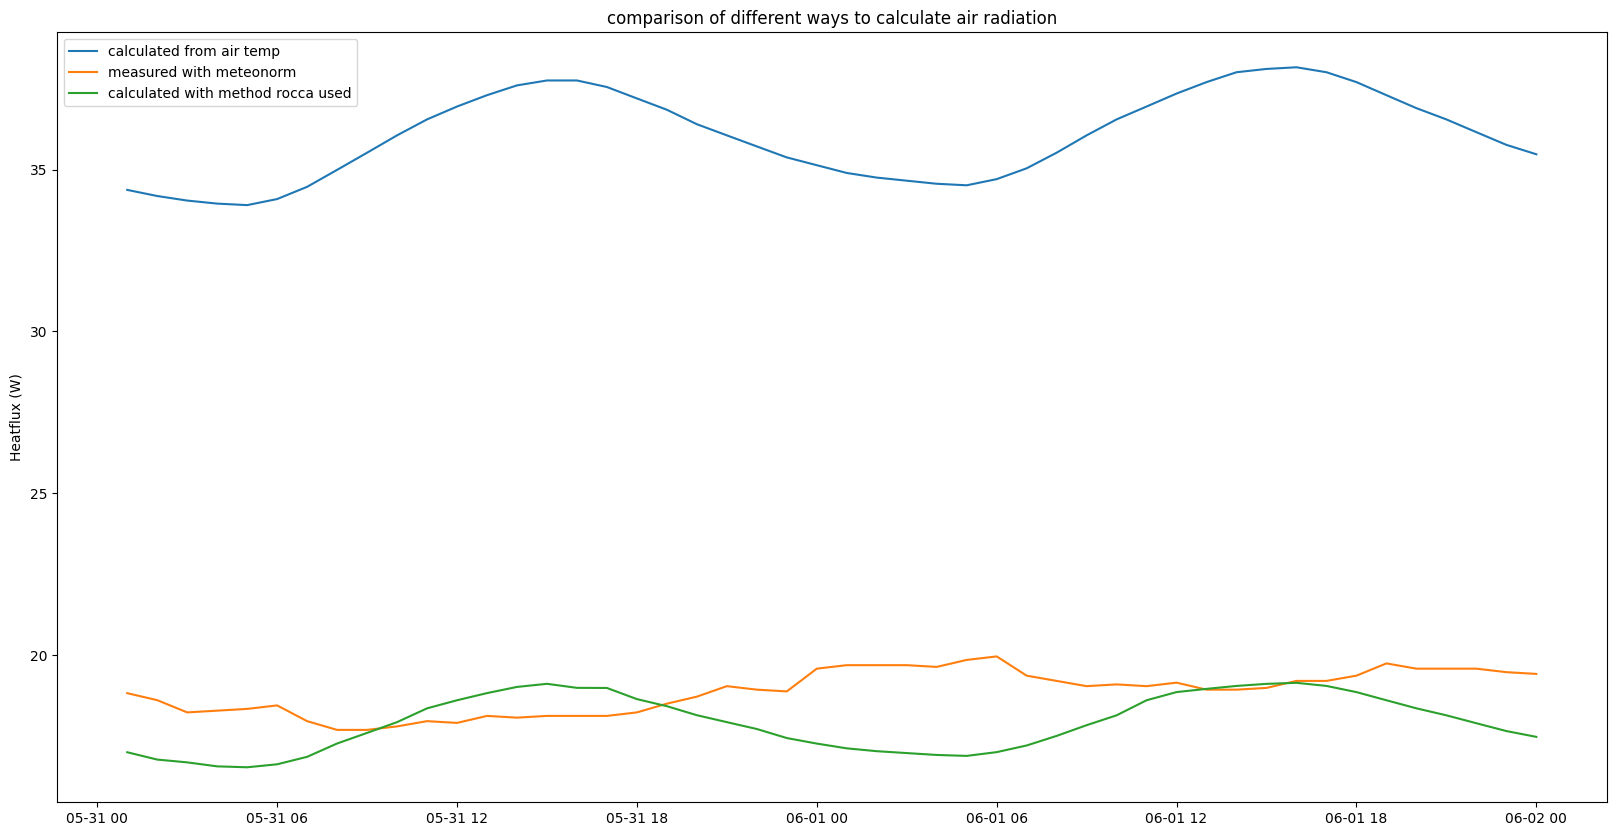

In [451]:
Q_air_calc = []
Q_air_meas = []
Q_air_rocca = []
clouds = []
wind = []
convection_vals = []
time_index = t_span[0]/3600
general_index = -1
for t in t_vals:
    time_index+=1
    general_index+=1
    try: 
        y = y_vals[general_index]
    except:
        pass
    Q_air_calc.append(infrared_rad_air2(t,y,time_index))
    Q_air_meas.append(infrared_rad_air(t,y,time_index))
    Q_air_rocca.append(infrared_rad_air_rocca(t,y,time_index))
    clouds.append(data.N[time_index])
    wind.append(data.FF[time_index])
    convection_vals.append(convection(t,y,time_index))
plt.plot(time_values,Q_air_calc,time_values,Q_air_meas,time_values,Q_air_rocca)
plt.legend(['calculated from air temp','measured with meteonorm','calculated with method rocca used'])
plt.title('comparison of different ways to calculate air radiation' )
plt.axis.titlesize=100
plt.ylabel('Heatflux (W)')


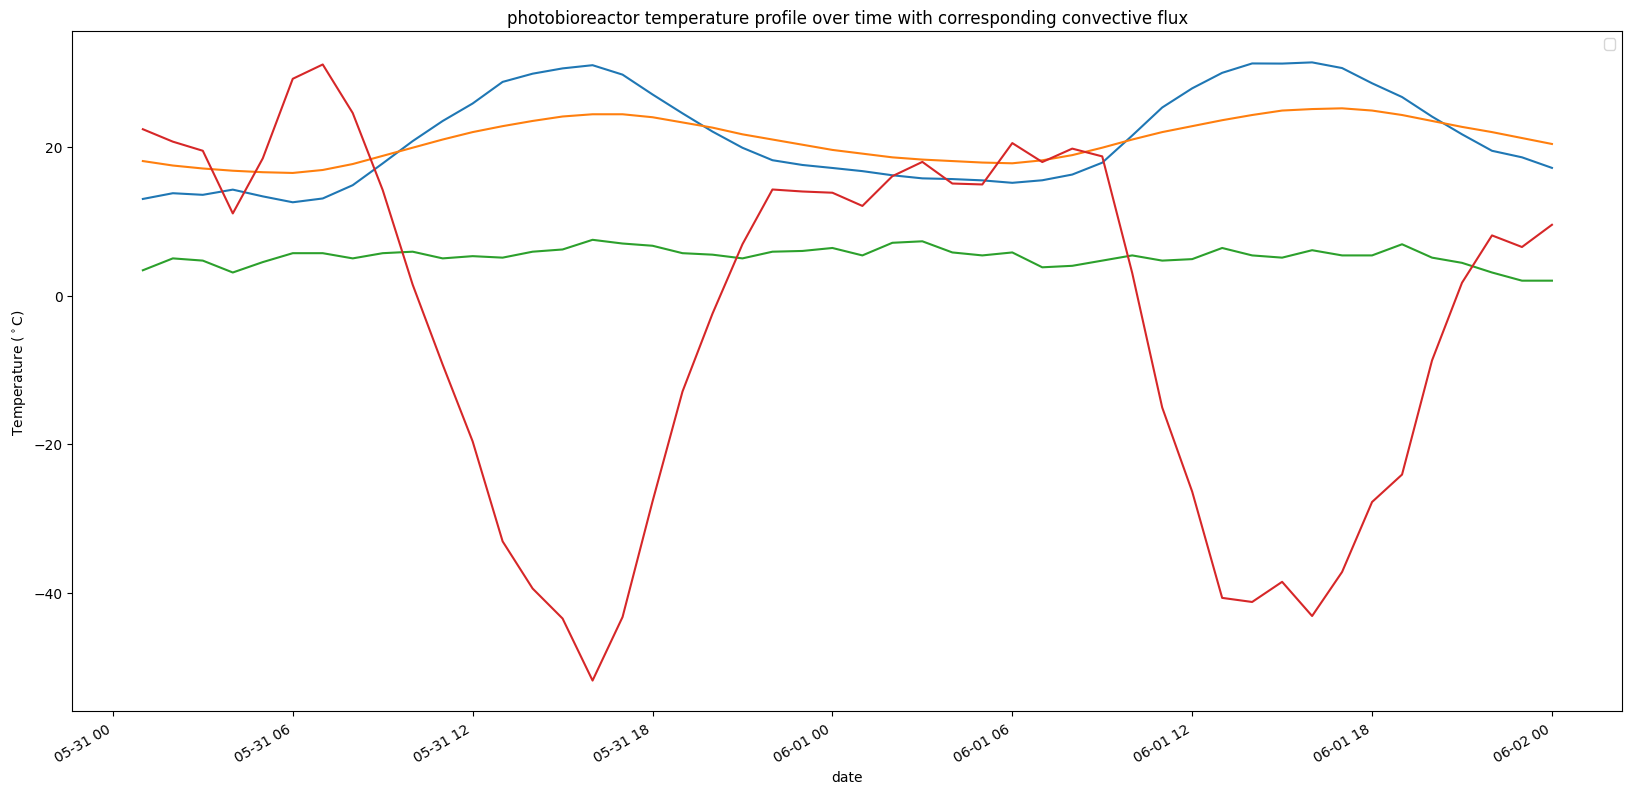

In [452]:
difference = air_temp-y_vals
plt.xlabel('date')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('photobioreactor temperature profile over time with corresponding convective flux')
plt.legend(['reactor temperature','air temperature','windspeed','convective flux'])
plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15,time_values,wind,time_values,convection_vals)
plt.gcf().autofmt_xdate()

In [449]:
Re_reactor = rho_reactor*flow_speed_reactor*(2*R_reactor)/mu_reactor
Re_air = rho_air*0*2*(R_reactor+glass_thickness)/mu_air 
Pr_air = cp_air*mu_air/k_air
Pr_reactor = cp_reactor*mu_reactor/k_reactor

empty_trial = []
empty_trial.append([2,4])
empty_trial.append([6,9])
A = np.array(empty_trial)
A[:,1]

array([4, 9])

np.float64(1.6)

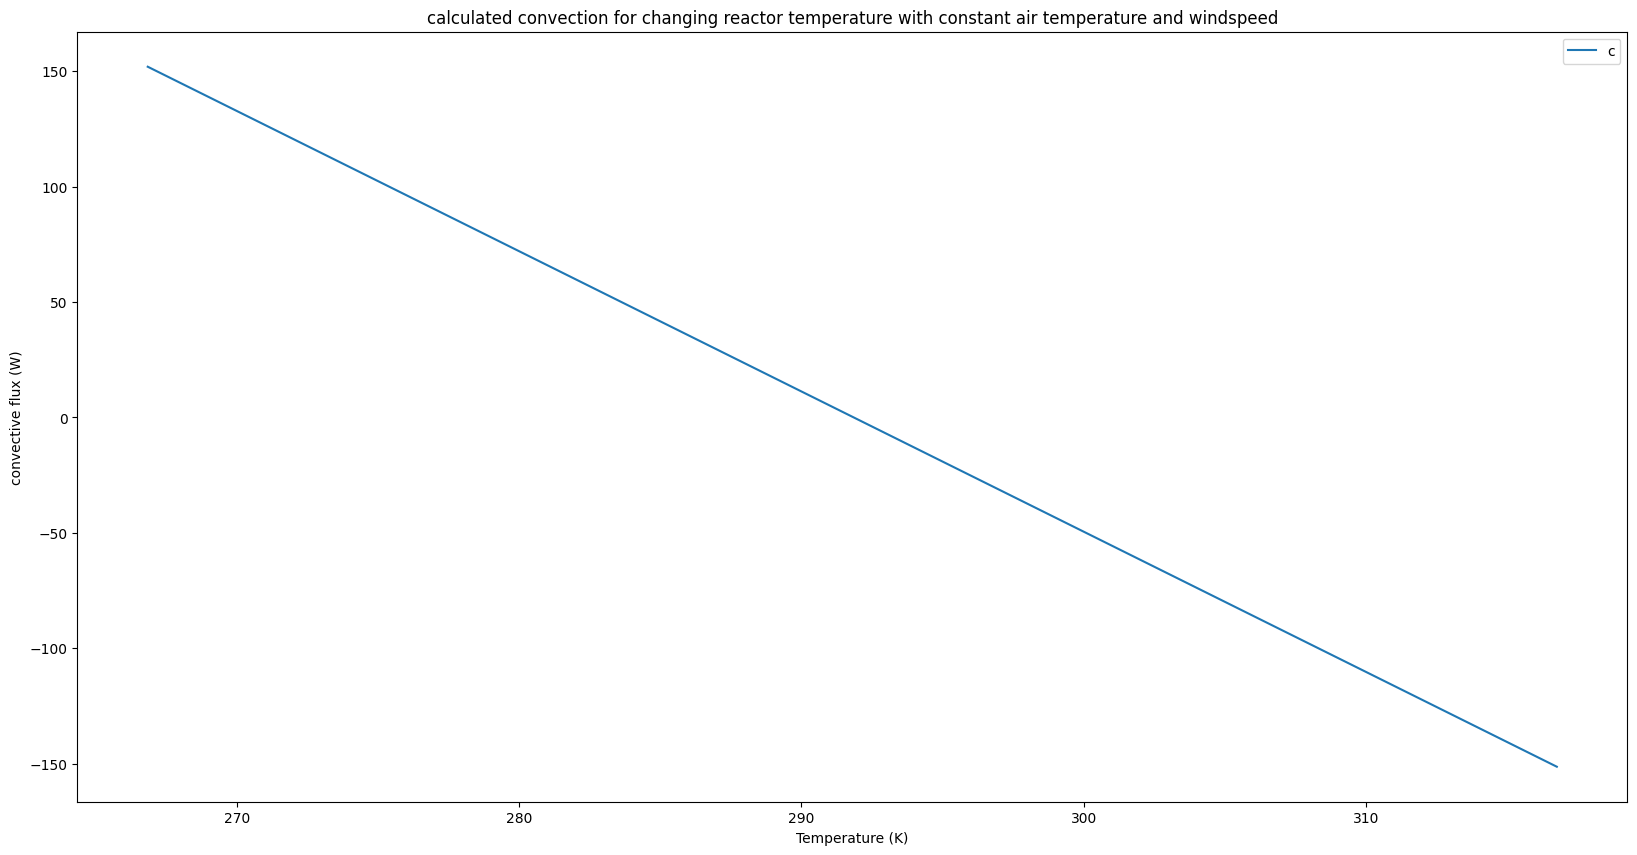

In [450]:
x_values = np.arange(data.Ta[15]-25,data.Ta[15]+25,0.1)
y_values = convection(15,x_values,15)
plt.plot(x_values,y_values)
plt.title('calculated convection for changing reactor temperature with constant air temperature and windspeed')
plt.legend('calculated convection')
plt.xlabel('Temperature (K)')
plt.ylabel('convective flux (W)')
data.FF[3]